In [1]:
# Laboratorio 3
## Microestructuras y Sistemas de Trading
###  Karen Medel y Pablo Mendoza


            TimeStamp      Open      High       Low     Close
0 2019-02-17 22:00:00  19.26516  19.26516  19.26352  19.26352
1 2019-02-17 22:05:00  19.26350  19.26438  19.26350  19.26399
2 2019-02-17 22:10:00  19.26398  19.26691  19.26372  19.26688
3 2019-02-17 22:15:00  19.26694  19.26710  19.26664  19.26702
4 2019-02-17 22:20:00  19.26700  19.26701  19.26688  19.26688
               TimeStamp      Open      High       Low     Close
3246 2019-03-05 04:30:00  19.31696  19.31960  19.31694  19.31712
3247 2019-03-05 04:35:00  19.31710  19.31728  19.31700  19.31700
3248 2019-03-05 04:40:00  19.31698  19.31716  19.31670  19.31687
3249 2019-03-05 04:45:00  19.31690  19.31705  19.31668  19.31697
3250 2019-03-05 04:50:00  19.31690  19.31723  19.31682  19.31717


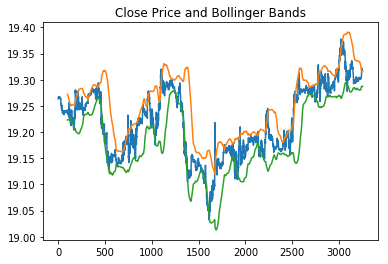

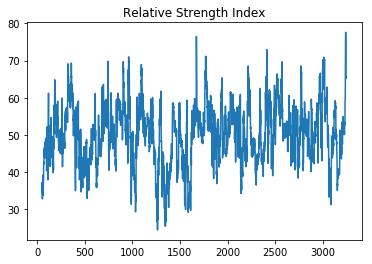

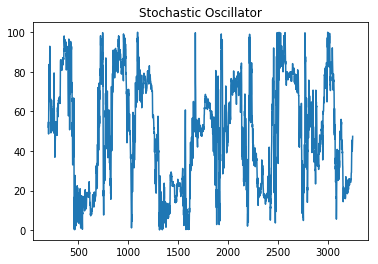

In [2]:
# -- Libraries Importation -- #
import ta as ta
import pandas as pd
import plotly as py
%matplotlib inline
from oandapyV20 import API
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import oandapyV20.endpoints.instruments as instruments
# -- DataFrame Parameters -- #
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
# -- OANDA Parameters -- #
A1_OA_Da = 16                     # Day Align
A1_OA_Ta = "America/Mexico_City"  # Time Align
A1_OA_Ai = "101-004-2221697-001"  # Id de cuenta
A1_OA_At = "practice"             # Tipo de cuenta
A1_OA_In = "USD_MXN"              # Instrumento
A1_OA_Gn = "M5"                   # Granularidad de velas (Minutes 5)
A1_OA_Ak = '4' + 'df969137c0bf800c5a04604c49450db-0e783d4124aa50b5736ebfe1a350eac' + '1'

# -- Data Range Function -- # 


def date_range(start_date_, end_date_, increment, period):
    """
    This function creates a list of the data range that will be imported
    :param start_date_: Start Date
    :param end_date_: End Date
    :param increment: number of increments
    :param period: type of increment (days, hours, minutes, etc)
    :return: list of the data range
    """
    result = []
    nxt = start_date_
    delta = relativedelta(**{period: increment})
    while nxt <= end_date_:
        result.append(nxt)
        nxt += delta
    return result


# -- Download Initial DAta -- #
start_date = date(2019, 2, 16)
end_date = date(2019, 3, 5)
date_a = date_range(start_date, end_date, 17, 'days')

F1 = date_a[0].strftime('%Y-%m-%dT%H:%M:%S')
F2 = date_a[1].strftime('%Y-%m-%dT%H:%M:%S')

# -- OANDA API Initialisation -- #
api = API(access_token=A1_OA_Ak)
# -- Historical DAta Download -- #
params = {"granularity": A1_OA_Gn, "price": "M", "dailyAlignment": A1_OA_Da,
          "alignmentTimezone": A1_OA_Ta, "from": F1, "to": F2}
A1_Req1 = instruments.InstrumentsCandles(instrument=A1_OA_In, params=params)
A1_Hist = api.request(A1_Req1)
list_a = []
for i in range(len(A1_Hist['candles'])-1):
        list_a.append({'TimeStamp': A1_Hist['candles'][i]['time'],
                       'Open': A1_Hist['candles'][i]['mid']['o'],
                       'High': A1_Hist['candles'][i]['mid']['h'],
                       'Low': A1_Hist['candles'][i]['mid']['l'],
                       'Close': A1_Hist['candles'][i]['mid']['c']})

pd_hist = pd.DataFrame(list_a)
pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])
pd_hist['Open'] = pd.to_numeric(pd_hist['Open'])
pd_hist['High'] = pd.to_numeric(pd_hist['High'])
pd_hist['Low'] = pd.to_numeric(pd_hist['Low'])
pd_hist['Close'] = pd.to_numeric(pd_hist['Close'])
print(pd_hist.head())
print(pd_hist.tail())
# -- Data Structure -- #
df1_Prices = pd_hist

# -- Indicators Functions from Technical Analysis (T.A.) -- #
# These functions will add a column to the Historical DataFrame with the value of the indicator.
# T.A. library has implemented 32 indicators:
## Volume
    # Accumulation/Distribution Index (ADI)
    # On-Balance Volume (OBV)
    # On-Balance Volume mean (OBV mean)
    # Chaikin Money Flow (CMF)
    # Force Index (FI)
    # Ease of Movement (EoM, EMV)
    # Volume-price Trend (VPT)
    # Negative Volume Index (NVI)
## Volatility
    # Average True Range (ATR)
    # Bollinger Bands (BB)
    # Keltner Channel (KC)
    # Donchian Channel (DC)
## Trend
    # Moving Average Convergence Divergence (MACD)
    # Average Directional Movement Index (ADX)
    # Vortex Indicator (VI)
    # Trix (TRIX)
    # Mass Index (MI)
    # Commodity Channel Index (CCI)
    # Detrended Price Oscillator (DPO)
    # KST Oscillator (KST)
    # Ichimoku Kinkō Hyō (Ichimoku)
## Momentum
    # Money Flow Index (MFI)
    # Relative Strength Index (RSI)
    # True strength index (TSI)
    # Ultimate Oscillator (UO)
    # Stochastic Oscillator (SR)
    # Williams %R (WR)
    # Awesome Oscillator (AO)
## Others
    # Daily Return (DR)
    # Daily Log Return (DLR)
    # Cumulative Return (CR)
# -- Exponential Moving Average (EMA) -- #
pd_hist['BBH_Close'] = ta.bollinger_hband(pd_hist['Close'], 100)
pd_hist['BBL_Close'] = ta.bollinger_lband(pd_hist['Close'], 100)
pd_hist['RSI_Close'] = ta.rsi(pd_hist['Close'], 50)
pd_hist['STO_Close'] = ta.momentum.stoch(pd_hist['High'], pd_hist['Low'], pd_hist['Close'], 200, False)

plt.figure(1)
plt.title('Close Price and Bollinger Bands')
plt.plot(pd_hist['Close'], label='Close')
plt.plot(pd_hist['BBH_Close'], label='BBH')
plt.plot(pd_hist['BBL_Close'], label='BBL')
plt.show()

plt.figure(2)
plt.title('Relative Strength Index')
plt.plot(pd_hist['RSI_Close'], label='RSI')
plt.show()

plt.figure(3)
plt.title('Stochastic Oscillator')
plt.plot(pd_hist['STO_Close'], label='Stochastic Oscillator')
plt.show()
# -- Indicators Functions to Open and Close positions -- #
# These functions will Open and Close positions depending of the values of each T.A. indicators.
# For opening operations, Take Profit (TP) level will be 2000 pips from spot.
# For closing operations, Stop Loss (SL) level will be 1000 pips from spot.
# TP and SL levels will be above or below spot depending if the position is Long or Short.




In [ ]:
# -- Operation DataFrame -- #






# -- Paso 2 -- en Data Frame (df2_operaciones)
# -- -- Fecha, Folio (1 a n), Operacion (1 = compra, -1 = venta), Unidades (0 a n),
# -- -- Margen (0 a n), Comentario ("razon con base al indicador")
# -- -- Precio_apertura, Precio_cierre

# -- Paso 3 -- en Data Frame Cuenta (df3_cuenta)
# -- -- Fecha, Capital (Efectivo $), Flotante ($),
# -- -- Balance (Capital+Flotante), Rend_Balance_acm, Comentario ("Se abrio operacion: compra/venta",
# -- -- "Se cerro operacion: Con perdia de: / Con ganancia de: ", 

# -- Paso 4 -- Generar un vector de fechas, de F1 hasta F2

par0_cap = 100000   # Capital a utilizar $100,000 Usd
par1_mar = 1000000  # Unidades por operacion maximo 1'000,000


# -- Criterios para trading
# -- para cerrar una operacion: 1) TP o SL, 2) Regla con indicador

indice = [1, 2, 3, 4, 5]
columnas = ['A','B', 'C', 'D']
df = pd.DataFrame(index=indice, columns=columnas)
df = df.fillna(0) # -- llenar todas las celdas con 0s



# -- ---------------------------------------------------------------- Agregar analisis tecnico -- #
# -- ---------------------------------------------------------------- ------------------------ -- #




# -- ------------------------------------------------------------------- --------------------- -- #
# -- ------------------------------------------------------------------- --------------------- -- #

trace0 = go.Scatter(x=pd_hist['TimeStamp'], y=pd_hist['ema_Close'],
                    mode='lines', name='lines0')

trace1 = go.Scatter(x=pd_hist['TimeStamp'], y=pd_hist['Close'],
                    mode='lines', name='lines1')

data = [trace0, trace1]

py.offline.plot(data, filename='file.html')




